In [1]:
# Topic:        Project 3
# Subject:      Market Basket Analysis of Instacart - Classification
# Date:         04/09/2020
# Name:         yalin yener

In [107]:
%%time
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from collections import OrderedDict
import time


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)



CPU times: user 189 μs, sys: 329 μs, total: 518 μs
Wall time: 535 μs


In [5]:
%%time
# Reading Files and Creating Data Frame
aisle = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")
products = pd.read_csv("data/products.csv")
orders = pd.read_csv("data/orders.csv")
order_products_prior = pd.read_csv('data/order_products__prior.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')

CPU times: user 6.12 s, sys: 1.42 s, total: 7.54 s
Wall time: 7.61 s


In [7]:
print("aisle: ",aisle.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisle:  (134, 2)
departments:  (21, 2)
orders:  (3421083, 7)
products:  (49688, 4)
order_products_prior:  (32434489, 4)
order_products_train:  (1384617, 4)


In [9]:
order_products_train.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [11]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
%%time
order_products_train = order_products_train.merge(orders.drop('eval_set', axis=1), on='order_id')
order_products_prior = order_products_prior.merge(orders.drop('eval_set', axis=1), on='order_id')

CPU times: user 4.53 s, sys: 1.6 s, total: 6.13 s
Wall time: 6.16 s


In [14]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,4,4,10,9.0
1,1,11109,2,1,112108,4,4,10,9.0
2,1,10246,3,0,112108,4,4,10,9.0
3,1,49683,4,0,112108,4,4,10,9.0
4,1,43633,5,1,112108,4,4,10,9.0


In [15]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,3,5,9,8.0
1,2,28985,2,1,202279,3,5,9,8.0
2,2,9327,3,0,202279,3,5,9,8.0
3,2,45918,4,1,202279,3,5,9,8.0
4,2,30035,5,0,202279,3,5,9,8.0


In [19]:
%%time
user_product = (order_products_prior.groupby(['product_id','user_id'],as_index=False) 
                                          .agg({'order_id':'count'}) 
                                          .rename(columns={'order_id':'user_product_total_orders'}))

train_ids = order_products_train['user_id'].unique() 
df_X = user_product[user_product['user_id'].isin(train_ids)]
df_X.shape

CPU times: user 11.4 s, sys: 1.26 s, total: 12.7 s
Wall time: 12.7 s


(8474661, 3)

In [21]:
user_product.head()

,product_id,user_id,user_product_total_orders
0,1,138,2
1,1,709,1
2,1,764,2
3,1,777,1
4,1,825,1


In [23]:
df_X.head()

,product_id,user_id,user_product_total_orders
0,1,138,2
1,1,709,1
3,1,777,1
6,1,1052,2
9,1,1494,3


In [1]:
%%time
train_carts = (order_products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

df_X.sample(5)

NameError: name 'order_products_train' is not defined

In [26]:
train_carts.head()

,user_id,latest_cart
0,1,"{196, 26405, 27845, 46149, 13032, 39657, 26088..."
1,2,"{24838, 11913, 45066, 31883, 48523, 38547, 248..."
2,5,"{40706, 21413, 20843, 48204, 21616, 19057, 201..."
3,7,"{17638, 29894, 47272, 45066, 13198, 37999, 408..."
4,8,"{27104, 15937, 5539, 41540, 31717, 48230, 2224..."


In [27]:
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart
0,1,138,2,{42475},0
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0
2,1,777,1,"{43352, 6184, 16797}",0
3,1,1052,2,{17207},0
4,1,1494,3,{44560},0


in_cart
0    0.9022
1    0.0978
Name: proportion, dtype: float64


<Axes: xlabel='in_cart'>

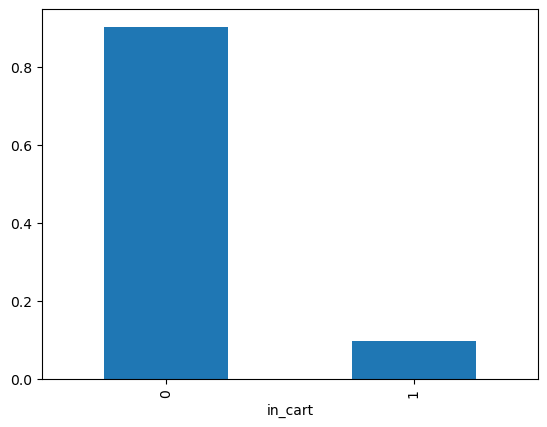

In [28]:
target_pcts = df_X.in_cart.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

CPU times: user 844 ms, sys: 156 ms, total: 1e+03 ms
Wall time: 579 ms


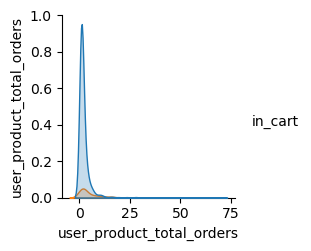

In [29]:
%%time
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['product_id','user_id','latest_cart'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='in_cart', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(df_X)

In [30]:
# Slice data into faeture and target

X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]

In [31]:
X.head()

,user_product_total_orders
0,2
1,1
2,1
3,2
4,3


In [32]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: in_cart, dtype: int64

In [33]:
#Split data into train, test and validation (%80 - %20)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [34]:
classifiers = [
    LogisticRegression()
    ]

In [35]:
log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log1 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log1 = pd.concat([log1, log_entry], ignore_index=True)
    
print("="*30)
round(log1,2)

LogisticRegression
****Results****
Accuracy: 90.1709%
Precision: 4.6610%
Recall: 47.1109%
F1 Score: 8.4828%
ROC AUC: 68.8511%
Log Loss: 0.301


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.17,4.66,47.11,8.48,68.85,0.3


In [3]:
# Feature Engineering V2,Adding Product Features

prod_features = ['product_total_orders','product_avg_add_to_cart_order']
df_prod_features = (order_products_prior.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))

NameError: name 'order_products_prior' is not defined

In [49]:
df_prod_features.head()

,product_id,order_id,add_to_cart_order
0,1,1852,5.801836
1,2,90,9.888889
2,3,277,6.415162
3,4,329,9.507599
4,5,15,6.466667


In [51]:
df_prod_features.columns = ['product_id'] + prod_features
df_prod_features.head(2)

,product_id,product_total_orders,product_avg_add_to_cart_order
0,1,1852,5.801836
1,2,90,9.888889


In [53]:
df_X = df_X.merge(df_prod_features, on='product_id')
df_X.head(2)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order
0,1,138,2,{42475},0,1852,5.801836
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852,5.801836


In [55]:
%%time
X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]

CPU times: user 82.2 ms, sys: 2.35 ms, total: 84.5 ms
Wall time: 84.1 ms


In [57]:
X.head()

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order
0,2,1852,5.801836
1,1,1852,5.801836
2,1,1852,5.801836
3,2,1852,5.801836
4,3,1852,5.801836


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [63]:
classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log2 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log2 = pd.concat([log2, log_entry], ignore_index=True)
    
print("="*30)
round(log2,2)

LogisticRegression
****Results****
Accuracy: 90.1991%
Precision: 5.0564%
Recall: 48.6411%
F1 Score: 9.1606%
ROC AUC: 69.6334%
Log Loss: 0.2955


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.2,5.06,48.64,9.16,69.63,0.3


In [65]:
%%time
# Feature Engineering V3,Adding User Features
user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_user_features = (order_products_prior.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')])))


CPU times: user 17.4 s, sys: 1.03 s, total: 18.4 s
Wall time: 18.6 s


In [66]:
df_user_features.head(3)

user_id order_id            product_id days_since_prior_order
           nunique <lambda_0>    nunique                   mean
0       1       10   5.900000         18              20.259259
1       2       14  13.928571        102              15.967033
2       3       12   7.333333         33              11.487179

In [69]:
df_user_features.columns = ['user_id'] + user_features

df_X = df_X.merge(df_user_features, on='user_id')
df_X = df_X.dropna() # note that this is naive NaN handling for simplicity

In [71]:
df_X.head()

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,1,138,2,{42475},0,1852,5.801836,32,4.625000,55,10.400000
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852,5.801836,5,38.400000,135,7.070968
2,1,777,1,"{43352, 6184, 16797}",0,1852,5.801836,26,4.346154,30,12.623853
3,1,1052,2,{17207},0,1852,5.801836,20,2.400000,24,10.914894
4,1,1494,3,{44560},0,1852,5.801836,13,12.153846,71,6.283582


In [73]:
X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X.head()

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,2,1852,5.801836,32,4.625000,55,10.400000
1,1,1852,5.801836,5,38.400000,135,7.070968
2,1,1852,5.801836,26,4.346154,30,12.623853
3,2,1852,5.801836,20,2.400000,24,10.914894
4,3,1852,5.801836,13,12.153846,71,6.283582


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [77]:

classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log3 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log3 = pd.concat([log3, log_entry], ignore_index=True)
    
print("="*30)
round(log3,2)

LogisticRegression
****Results****
Accuracy: 90.3622%
Precision: 8.0821%
Recall: 54.6873%
F1 Score: 14.0829%
ROC AUC: 72.7861%
Log Loss: 0.2844


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.36,8.08,54.69,14.08,72.79,0.28


In [78]:
%%time
# Feature Engineering V4 Adding User-Product Features

user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (order_products_prior.groupby(['product_id','user_id'],as_index=False) \
                                                .agg(OrderedDict(
                                                     [('add_to_cart_order','mean')])))


CPU times: user 13.2 s, sys: 1.4 s, total: 14.6 s
Wall time: 14.7 s


In [79]:
df_user_prod_features.head(3)

,product_id,user_id,add_to_cart_order
0,1,138,3.0
1,1,709,20.0
2,1,764,10.5


In [83]:
df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 

df_X = df_X.merge(df_user_prod_features,on=['user_id','product_id'])
df_X.head(2)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.400000,3.0
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852,5.801836,5,38.400,135,7.070968,20.0


In [85]:
%%time
df_X['user_product_order_freq'] = df_X['user_product_total_orders'] / df_X['user_total_orders'] 
df_X.head(2)

CPU times: user 87.4 ms, sys: 8.05 ms, total: 95.5 ms
Wall time: 28.4 ms


,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.400000,3.0,0.0625
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852,5.801836,5,38.400,135,7.070968,20.0,0.2000


In [87]:
#Model V4
X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X.head(3)

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq
0,2,1852,5.801836,32,4.625000,55,10.400000,3.0,0.062500
1,1,1852,5.801836,5,38.400000,135,7.070968,20.0,0.200000
2,1,1852,5.801836,26,4.346154,30,12.623853,7.0,0.038462


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [91]:
%%time
classifiers = [
    LogisticRegression()]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log4 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log4 = pd.concat([log4, log_entry], ignore_index=True)
    
print("="*30)
round(log4,2)

LogisticRegression
****Results****
Accuracy: 90.3364%
Precision: 3.5466%
Recall: 59.3914%
F1 Score: 6.6936%
ROC AUC: 74.9547%
Log Loss: 0.293
CPU times: user 1min 55s, sys: 25.6 s, total: 2min 20s
Wall time: 42.5 s


In [93]:
# Feature Engineering V5, Adding Product Category

prod_dep = products.merge(departments, on="department_id")
prod_dep = prod_dep[["product_id","department"]]
prod_dep.head(2)

,product_id,department
0,1,snacks
1,2,pantry


In [95]:
df_X = df_X.merge(prod_dep,on="product_id")
df_X.head(2)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,department
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.400000,3.0,0.0625,snacks
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852,5.801836,5,38.400,135,7.070968,20.0,0.2000,snacks


In [97]:
df_X = pd.concat([df_X.drop('department',axis=1),pd.get_dummies(df_X["department"])],axis=1)
df_X.head(2)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
0,1,138,2,{42475},0,1852,5.801836,32,4.625,55,10.400000,3.0,0.0625,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852,5.801836,5,38.400,135,7.070968,20.0,0.2000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [101]:
X= df_X.drop(columns=["in_cart","latest_cart","product_id","user_id"])
y= df_X.loc[:,"in_cart"]
X.head(3)

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
0,2,1852,5.801836,32,4.625000,55,10.400000,3.0,0.062500,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1,1852,5.801836,5,38.400000,135,7.070968,20.0,0.200000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,1,1852,5.801836,26,4.346154,30,12.623853,7.0,0.038462,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [105]:
%%time
classifiers = [
    LogisticRegression(),
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log5 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log5 = pd.concat([log5, log_entry], ignore_index=True)
    
print("="*30)
round(log5,2)

LogisticRegression
****Results****
Accuracy: 90.2226%
Precision: 1.4036%
Recall: 49.2480%
F1 Score: 2.7293%
ROC AUC: 69.7925%
Log Loss: 0.303
CPU times: user 7min 51s, sys: 47 s, total: 8min 38s
Wall time: 1min 48s


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.22,1.4,49.25,2.73,69.79,0.3


In [111]:
%%time
classifiers = [
    LogisticRegression(),
    # KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    # RandomForestClassifier(),
    # AdaBoostClassifier(),
    # GradientBoostingClassifier(),
    GaussianNB()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log5_1 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    start = time.time()
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    print(f'Time taken to train {name}: {time.time() - start}')
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log5_1 = pd.concat([log5_1, log_entry], ignore_index=True)
    print(f'Total Time taken for {name}: {time.time() - start}')
print("="*30)
round(log5_1,3)

LogisticRegression
Time taken to train LogisticRegression: 107.46622896194458
****Results****
Accuracy: 90.2226%
Precision: 1.4036%
Recall: 49.2480%
F1 Score: 2.7293%
ROC AUC: 69.7925%
Log Loss: 0.303
Total Time taken for LogisticRegression: 111.54068613052368
DecisionTreeClassifier
Time taken to train DecisionTreeClassifier: 218.7555148601532
****Results****
Accuracy: 84.2284%
Precision: 25.8569%
Recall: 22.8642%
F1 Score: 24.2687%
ROC AUC: 57.3588%
Log Loss: 5.685
Total Time taken for DecisionTreeClassifier: 229.425546169281
GaussianNB
Time taken to train GaussianNB: 8.316396951675415
****Results****
Accuracy: 88.7426%
Precision: 17.2086%
Recall: 34.6923%
F1 Score: 23.0056%
ROC AUC: 63.0943%
Log Loss: 0.5738
Total Time taken for GaussianNB: 16.264079093933105
CPU times: user 11min 59s, sys: 54.3 s, total: 12min 53s
Wall time: 5min 57s


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.223,1.404,49.248,2.729,69.793,0.303
1,DecisionTreeClassifier,84.228,25.857,22.864,24.269,57.359,5.685
2,GaussianNB,88.743,17.209,34.692,23.006,63.094,0.574


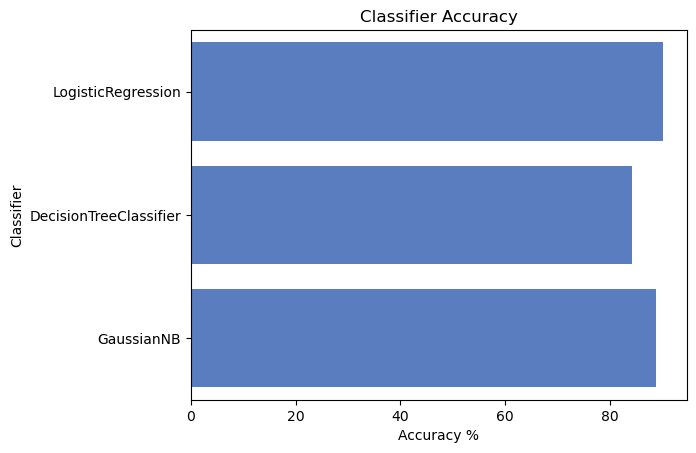

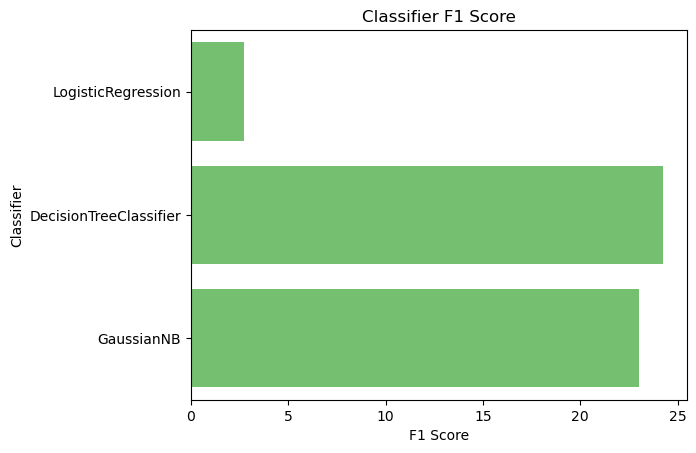

CPU times: user 437 ms, sys: 133 ms, total: 570 ms
Wall time: 236 ms


In [113]:
%%time
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log5_1, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='F1Score', y='Classifier', data=log5_1, color="g")

plt.xlabel('F1 Score')
plt.title('Classifier F1 Score')

plt.show()

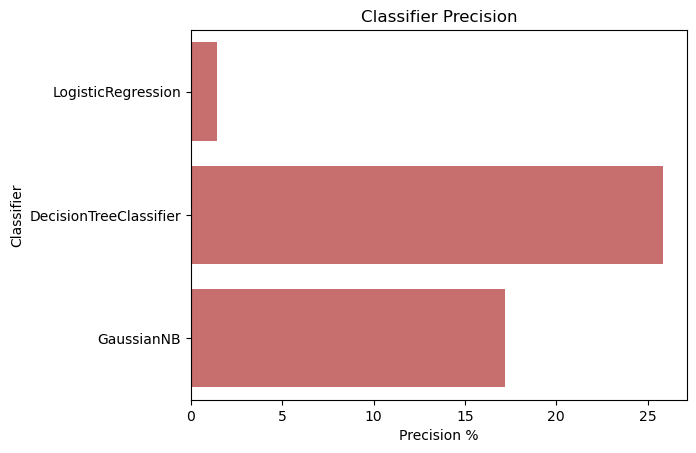

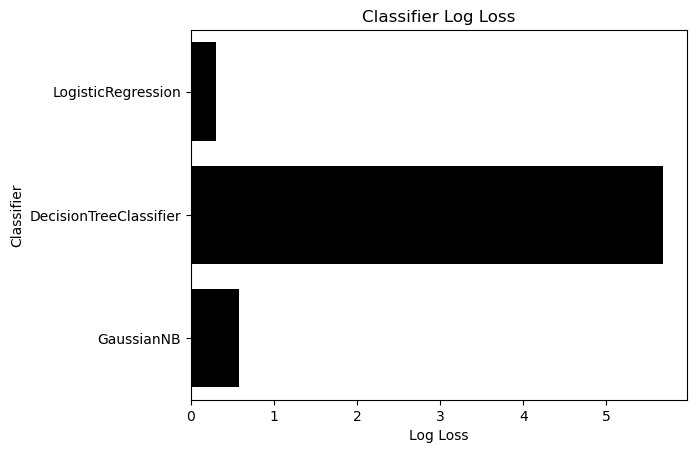

CPU times: user 435 ms, sys: 110 ms, total: 545 ms
Wall time: 206 ms


In [115]:
%%time
sns.set_color_codes("muted")
sns.barplot(x='Precision', y='Classifier', data=log5_1, color="r")

plt.xlabel('Precision %')
plt.title('Classifier Precision')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log5_1, color="black")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')

plt.show()

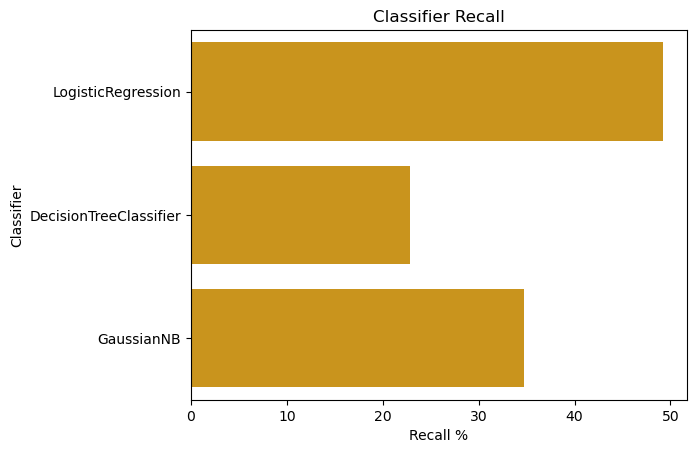

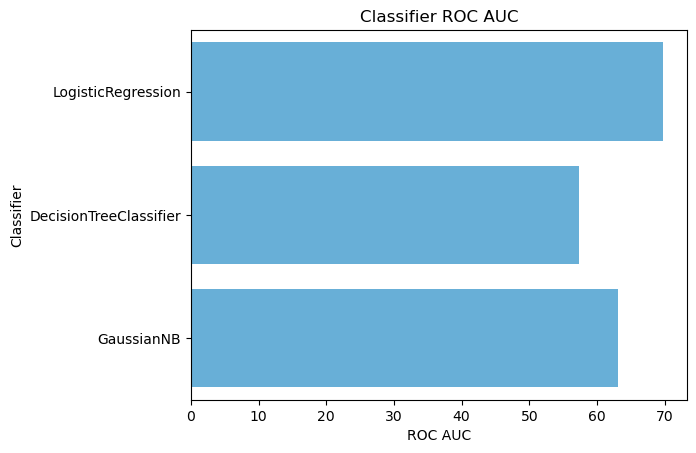

CPU times: user 440 ms, sys: 132 ms, total: 572 ms
Wall time: 226 ms


In [119]:
%%time
sns.set_color_codes("muted")
sns.barplot(x='Recall', y='Classifier', data=log5_1, color="#E69F00")

plt.xlabel('Recall %')
plt.title('Classifier Recall')
plt.show()


sns.set_color_codes("muted")
sns.barplot(x='ROC AUC', y='Classifier', data=log5_1, color="#56B4E9")

plt.xlabel('ROC AUC')
plt.title('Classifier ROC AUC')

plt.show()

Time taken to train GaussianNB: 7.14562201499939
Confusion matrix
[[1475621   53662]
 [ 137144   28506]]
Normalized confusion matrix
[[0.96 0.04]
 [0.83 0.17]]


<Figure size 3000x2000 with 0 Axes>

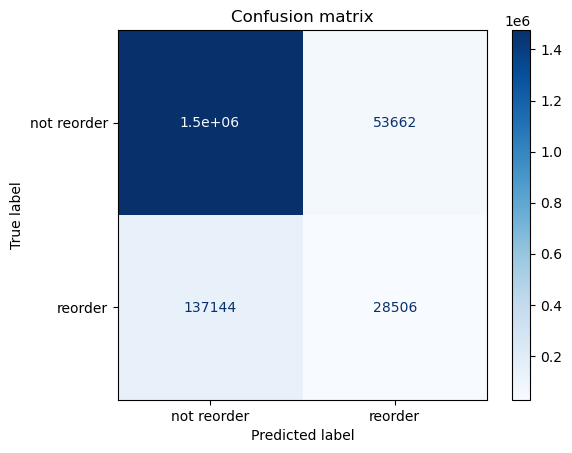

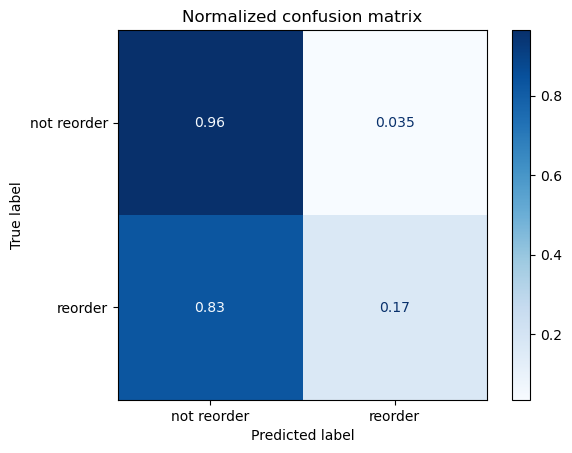

CPU times: user 7.03 s, sys: 3.54 s, total: 10.6 s
Wall time: 10.5 s


In [121]:
%%time
start = time.time()
classifier = GaussianNB().fit(X_train, y_train)
print(f'Time taken to train GaussianNB: {time.time() - start}')

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    # Compute confusion matrix
    cm = confusion_matrix(y_test, classifier.predict(X_test), normalize=normalize)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["not reorder", "reorder"])
    disp.plot(cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


Confusion matrix
[[1475621   53662]
 [ 137144   28506]]
Normalized confusion matrix
[[0.96 0.04]
 [0.83 0.17]]


<Figure size 3000x2000 with 0 Axes>

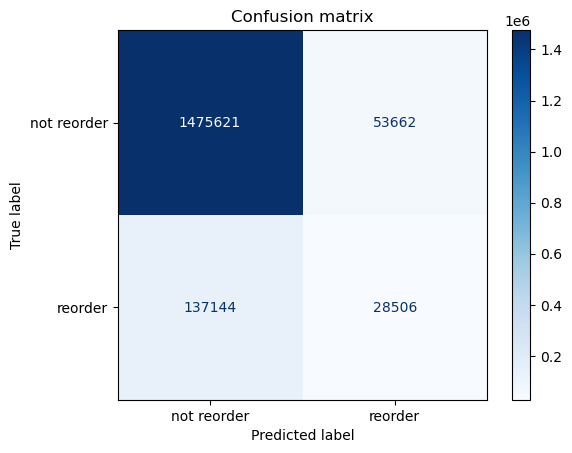

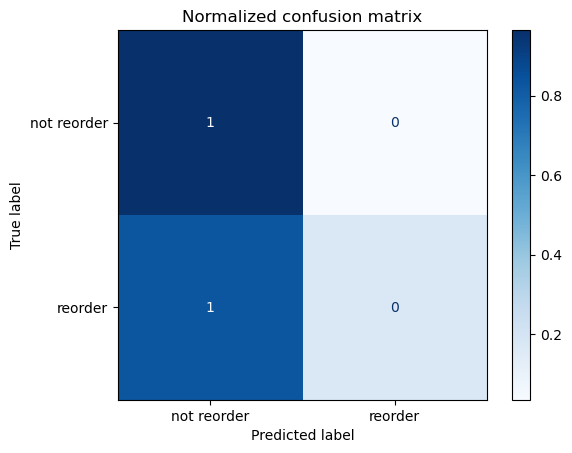

CPU times: user 2.25 s, sys: 450 ms, total: 2.7 s
Wall time: 2.38 s


In [123]:
%%time
# Train the classifier
# classifier = GaussianNB().fit(X_train, y_train)

# Set print options for numpy arrays
np.set_printoptions(precision=2)

# Set up the plot
plt.figure(figsize=(15, 10), dpi=200)
plt.style.use('default')

# Plot non-normalized and normalized confusion matrices
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    # Compute confusion matrix
    cm = confusion_matrix(y_test, classifier.predict(X_test), normalize=normalize)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["not reorder", "reorder"])
    disp.plot(cmap=plt.cm.Blues, values_format='.0f')
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


In [125]:
%%time
start = time.time()
clf = DecisionTreeClassifier()
#Fit with all the training set
clf.fit(X_train, y_train)
print(f'Time taken to train DecisionTreeClassifier: {time.time() - start}')
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

print("Feature Importance:")
for f in range(X.shape[1]):
    print("%s : (%f)" % (feature_names[f] , importances[indices[f]]))

Time taken to train DecisionTreeClassifier: 221.70638513565063
Feature Importance:
user_product_total_orders : (0.163572)
product_total_orders : (0.148611)
product_avg_add_to_cart_order : (0.124965)
user_total_orders : (0.117769)
user_avg_cartsize : (0.116350)
user_total_products : (0.111454)
user_avg_days_since_prior_order : (0.107075)
user_product_avg_add_to_cart_order : (0.026759)
user_product_order_freq : (0.016285)
alcohol : (0.008551)
babies : (0.007990)
bakery : (0.006418)
beverages : (0.006137)
breakfast : (0.005267)
bulk : (0.004583)
canned goods : (0.004327)
dairy eggs : (0.003321)
deli : (0.003249)
dry goods pasta : (0.003132)
frozen : (0.002749)
household : (0.002697)
international : (0.002518)
meat seafood : (0.001445)
missing : (0.001205)
other : (0.001196)
pantry : (0.000682)
personal care : (0.000648)
pets : (0.000444)
produce : (0.000309)
snacks : (0.000293)
CPU times: user 3min 38s, sys: 1.79 s, total: 3min 39s
Wall time: 3min 41s


In [126]:
X.head(3)

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
0,2,1852,5.801836,32,4.625000,55,10.400000,3.0,0.062500,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1,1852,5.801836,5,38.400000,135,7.070968,20.0,0.200000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,1,1852,5.801836,26,4.346154,30,12.623853,7.0,0.038462,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [127]:
df_X.head(3)

,product_id,user_id,user_product_total_orders,latest_cart,in_cart,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_product_avg_add_to_cart_order,user_product_order_freq,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
0,1,138,2,{42475},0,1852,5.801836,32,4.625000,55,10.400000,3.0,0.062500,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,1,709,1,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1852,5.801836,5,38.400000,135,7.070968,20.0,0.200000,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,1,777,1,"{43352, 6184, 16797}",0,1852,5.801836,26,4.346154,30,12.623853,7.0,0.038462,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [128]:
X=X[["user_product_total_orders","product_total_orders","product_avg_add_to_cart_order","user_total_orders",
     "user_avg_cartsize","user_total_products","user_avg_days_since_prior_order"]]
y= df_X.loc[:,"in_cart"]

In [129]:
X.head(2)

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,2,1852,5.801836,32,4.625,55,10.400000
1,1,1852,5.801836,5,38.400,135,7.070968


In [130]:
y.head(2)

0    0
1    0
Name: in_cart, dtype: int64

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=5)

In [139]:
%%time
classifiers = [
    LogisticRegression(),
    # KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    # RandomForestClassifier(),
    # AdaBoostClassifier(),
    # GradientBoostingClassifier(),
    GaussianNB()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log6 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    start = time.time()
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    print(f'Time taken to train {name}: {time.time() - start}')
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log6 = pd.concat([log6, log_entry], ignore_index=True)
    print(f'Total Time taken for {name}: {time.time() - start}')

print("="*30)
round(log6,3)

LogisticRegression
Time taken to train LogisticRegression: 35.04698395729065
****Results****
Accuracy: 90.3622%
Precision: 8.0821%
Recall: 54.6873%
F1 Score: 14.0829%
ROC AUC: 72.7861%
Log Loss: 0.2844
Total Time taken for LogisticRegression: 38.02906775474548
DecisionTreeClassifier
Time taken to train DecisionTreeClassifier: 122.6717529296875
****Results****
Accuracy: 84.4168%
Precision: 26.0320%
Recall: 23.3446%
F1 Score: 24.6152%
ROC AUC: 57.6157%
Log Loss: 5.616
Total Time taken for DecisionTreeClassifier: 132.70909786224365
GaussianNB
Time taken to train GaussianNB: 1.2276451587677002
****Results****
Accuracy: 88.7577%
Precision: 16.8017%
Recall: 34.5464%
F1 Score: 22.6080%
ROC AUC: 63.0047%
Log Loss: 0.5712
Total Time taken for GaussianNB: 5.321128845214844
CPU times: user 3min 56s, sys: 25.3 s, total: 4min 22s
Wall time: 2min 56s


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,LogisticRegression,90.362,8.082,54.687,14.083,72.786,0.284
1,DecisionTreeClassifier,84.417,26.032,23.345,24.615,57.616,5.616
2,GaussianNB,88.758,16.802,34.546,22.608,63.005,0.571


In [140]:
%%time
target_count = df_X.in_cart.value_counts()
target_count

CPU times: user 45.7 ms, sys: 11 ms, total: 56.8 ms
Wall time: 58.1 ms


in_cart
0    7645837
1     828824
Name: count, dtype: int64

In [141]:
%%time
# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 7645837
Class 1: 828824
Proportion: 9.22 : 1
Percentage of Majority Class: 90.22
CPU times: user 498 μs, sys: 204 μs, total: 702 μs
Wall time: 553 μs


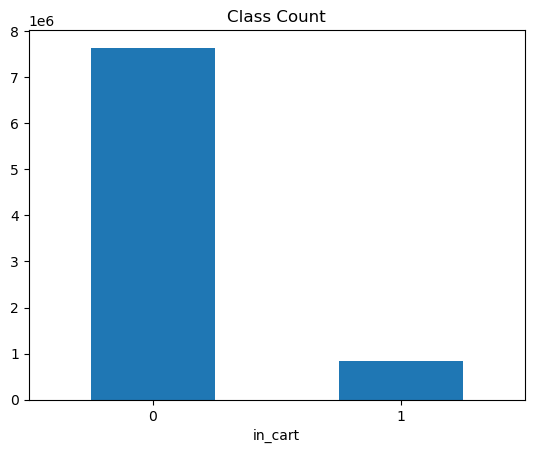

In [142]:
target_count.plot(kind='bar', title='Class Count', rot=0);

In [143]:
#Oversampling
#!pip install imblearn

In [144]:
#pip install -U imbalanced-learn 

In [146]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


In [147]:
X.head()

,user_product_total_orders,product_total_orders,product_avg_add_to_cart_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order
0,2,1852,5.801836,32,4.625000,55,10.400000
1,1,1852,5.801836,5,38.400000,135,7.070968
2,1,1852,5.801836,26,4.346154,30,12.623853
3,2,1852,5.801836,20,2.400000,24,10.914894
4,3,1852,5.801836,13,12.153846,71,6.283582


In [148]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: in_cart, dtype: int64

In [160]:
%%time
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X,y)

CPU times: user 3.05 s, sys: 887 ms, total: 3.94 s
Wall time: 3.95 s


In [162]:
%%time
classifiers = [
    RandomForestClassifier()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log7 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    start = time.time()
    clf.fit(X_resampled, y_resampled)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    print(f'Time taken to train {name}: {time.time() - start}')
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log7 = pd.concat([log7, log_entry], ignore_index=True)
    print(f'Total Time taken for {name}: {time.time() - start}')
    
print("="*30)
round(log7,3)

RandomForestClassifier
Time taken to train RandomForestClassifier: 7927.43572306633
****Results****
Accuracy: 99.9903%
Precision: 100.0000%
Recall: 99.9005%
F1 Score: 99.9502%
ROC AUC: 99.9502%
Log Loss: 0.04092
Total Time taken for RandomForestClassifier: 8791.320125102997


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,RandomForestClassifier,99.99,100.0,99.9,99.95,99.95,0.041


In [163]:
%%time
ros = RandomOverSampler(random_state=0)
X_smoted, y_smoted = SMOTE(random_state=42).fit_resample(X,y)

CPU times: user 17.1 s, sys: 3.95 s, total: 21 s
Wall time: 22.3 s


In [164]:
%%time
classifiers = [
    
    KNeighborsClassifier()
    ]

log_cols=["Classifier", "Accuracy", "Precision","Recall","F1Score","ROC AUC","Log Loss"]
log8 = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    start = time.time()
    clf.fit(X_smoted, y_smoted)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    print(f'Time taken to train {name}: {time.time() - start}')
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    f1 = f1_score(clf.predict(X_test),y_test)
    pre = precision_score(clf.predict(X_test),y_test)
    rec = recall_score(clf.predict(X_test),y_test)
    auc = roc_auc_score(clf.predict(X_test),y_test)
    print("Accuracy: {:.4%}".format(acc))
    print("Precision: {:.4%}".format(pre))
    print("Recall: {:.4%}".format(rec))
    print("F1 Score: {:.4%}".format(f1))
    print("ROC AUC: {:.4%}".format(auc))

    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {:.4}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, pre*100, rec*100,f1*100,auc*100,ll]], columns=log_cols)
    log8 = pd.concat([log8, log_entry], ignore_index=True)
    print(f'Total Time taken for {name}: {time.time() - start}')
    
print("="*30)
round(log8,3)

KNeighborsClassifier
Time taken to train KNeighborsClassifier: 40.135714054107666
****Results****
Accuracy: 83.4307%
Precision: 99.4392%
Recall: 37.0468%
F1 Score: 53.9821%
ROC AUC: 68.4862%
Log Loss: 0.2835
Total Time taken for KNeighborsClassifier: 993.808562040329


,Classifier,Accuracy,Precision,Recall,F1Score,ROC AUC,Log Loss
0,KNeighborsClassifier,83.431,99.439,37.047,53.982,68.486,0.283


In [ ]:
%%time
scores1 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="accuracy")
scores2 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="recall")
scores3 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="precision")
scores4 = cross_val_score(RandomForestClassifier(), X_smoted, y_smoted, cv=10, scoring="f1_macro")

print("Mean Accuracy: ", scores1.mean())
print("Mean Precision: ", scores3.mean())
print("Mean Recall: ", scores2.mean())
print("Mean F1 Score: ", scores4.mean())


In [ ]:
%%time
# using the default threshold of 0.5, which is what vanilla predict does
y_predict = clf.predict(X_smoted)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_smoted, y_predict), 
                                                     recall_score(y_smoted, y_predict)))

In [ ]:
%%time
# using the new threshold of 0.06
y_predict = (clf.predict_proba(X_test)[:,1] > 0.07)
print("Threshold of 0.06:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

In [ ]:
%%time
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score


precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_smoted, clf.predict_proba(X_smoted)[:,1] )

plt.figure(figsize=(10,7),dpi=100),
plt.style.use('default')
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability');
plt.title('Precision and Recall Curves');

In [ ]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [ ]:
%%time
start = time.time()
classifier = KNeighborsClassifier().fit(X_smoted, y_smoted)
print(f'Time taken to train KNeighborsClassifier: {time.time() - start}')

np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,values_format='.0f'
                                 )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [ ]:
%%time
start = time.time()
classifier = KNeighborsClassifier().fit(X_train, y_train)
print(f'Time taken to train KNeighborsClassifier: {time.time() - start}')
np.set_printoptions(precision=2)
plt.figure(figsize=(15,10),dpi=200),
plt.style.use('default')

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=["not reorder","reorder"],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()